# Modelo de clustering y clasificación con datos de Airbnb Madrid 

Para este proyecto se ha extraido una tabla con datos de airbnb del último año de la web insideairbnb. En base a estos datos, y tras su análisis y limpieza, se ha elaborado un modelo de clustering y usado dichos clusters para hacer un modelo de clasificación.

A la hora de limpiar los datos, en primer lugar se separaron los datos categóricos con columnas dummies, algo que afectaba principalmente a la columna de distrito creando más de 20 columnas dummies. Una vez comprobado que el modelo de clustering no parecía funcionar, la solución elegida ha sido hacer la mediana del precio de cada distrito y darle ese valor a la columna distrito.

Debido al tamaño de la tabla original, no se ha subido a Github, pero se puede descargar aquí: https://drive.google.com/file/d/1pzuOFKPMfB31FODWKiyI_xJ7KYMBPiBp/view?usp=sharing

La tabla limpia con la que se han creado los modelos si está disponible en la carpeta del proyecto, lugar donde también se encuentra un pdf con las conclusiones más importantes a las que se ha llegado.

### 1. Importación librerías y datos

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df_airbnb = pd.read_csv('listings.csv')

In [3]:
df_airbnb.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

In [4]:
df_airbnb.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,6369,https://www.airbnb.com/rooms/6369,20230315024316,2023-03-15,city scrape,"Rooftop terrace room , ensuite bathroom",Excellent connection with the AIRPORT and EXHI...,NaN,https://a0.muscache.com/pictures/683224/4cc318...,13660,...,4.86,4.83,4.86,NaN,f,1,0,1,0,0.64
1,21853,https://www.airbnb.com/rooms/21853,20230315024316,2023-03-15,city scrape,Bright and airy room,We have a quiet and sunny room with a good vie...,We live in a leafy neighbourhood with plenty o...,https://a0.muscache.com/pictures/68483181/87bc...,83531,...,4.82,4.21,4.67,NaN,f,2,0,2,0,0.32
2,24805,https://www.airbnb.com/rooms/24805,20230315024316,2023-03-15,city scrape,Gran Via Studio Madrid,"Studio located 50 meters from Gran Via, next t...","The area is next to the Gran Via, so people li...",https://a0.muscache.com/pictures/miso/Hosting-...,346366726,...,4.88,4.96,4.69,NaN,f,1,1,0,0,0.26
3,26825,https://www.airbnb.com/rooms/26825,20230315024316,2023-03-15,city scrape,Single Room whith private Bathroom,Nice and cozy roon for one person with a priva...,"Es un barrio muy tranquilo, en una zona de Mad...",https://a0.muscache.com/pictures/149358/218d5b...,114340,...,4.71,4.73,4.75,NaN,f,1,0,1,0,1.18
4,30320,https://www.airbnb.com/rooms/30320,20230315024316,2023-03-15,city scrape,Great Vacational Apartments,<b>The space</b><br />Fully furnished spacious...,NaN,https://a0.muscache.com/pictures/336868/f67409...,130907,...,4.78,4.90,4.69,NaN,f,3,3,0,0,1.11


In [6]:
df_airbnb.isna().sum().sort_values(ascending=False).head(34)

calendar_updated               21239
bathrooms                      21239
license                        18494
host_neighbourhood             11010
host_about                     11005
neighbourhood                   9475
neighborhood_overview           9475
host_location                   5904
host_response_time              5057
host_response_rate              5057
review_scores_value             4214
review_scores_location          4213
review_scores_accuracy          4211
review_scores_communication     4211
review_scores_checkin           4210
review_scores_cleanliness       4209
host_acceptance_rate            4169
reviews_per_month               4071
first_review                    4071
last_review                     4071
review_scores_rating            4071
bedrooms                        1572
description                      618
beds                             303
bathrooms_text                    19
name                               4
host_is_superhost                  4
h

Las columnas con muchos NaN son, en su mayoría, columnas con las que ni siquiera se va a operar.
La única que realmente importa es bedrooms y bed, ya que sí que vamos a trabajar con ellas.

Más adelante se limpiarán.

### 2. Limpieza y manipulación de datos

Lo primero es hacer una función para convertir bathrooms_text (en formato 1 shared bath, 2 private baths...) a una columna que únicamente nos pase el número de baños o, en caso de que sean compartidos, nos devuelva 0. O sea, que acabaremos con una columna que sea la cantidad de baños privados que se tienen.

In [8]:
# Antes eliminamos los NaN de la columna sobre la que trabajaremos.
df_airbnb.dropna(subset=['bathrooms_text'], inplace=True)

def transform_bathrooms_text(text):
    if "shared bath" in text:
        return 0
    else:
        num_bathrooms = ''.join(filter(str.isdigit, text))
        return float(num_bathrooms) if num_bathrooms else 0

df_airbnb['bathrooms'] = df_airbnb['bathrooms_text'].apply(transform_bathrooms_text)



Ahora haremos subsetting de las columnas que nos interesan para nuestro análisis

In [9]:
df_airbnb_clean = df_airbnb[['neighbourhood_group_cleansed', 'room_type', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews','availability_365']].copy()
df_airbnb_clean.head()

,neighbourhood_group_cleansed,room_type,bathrooms,bedrooms,beds,price,number_of_reviews,availability_365
0,Chamartín,Private room,1.0,1.0,1.0,$90.00,102,168
1,Latina,Private room,1.0,1.0,1.0,$31.00,33,226
2,Centro,Entire home/apt,1.0,NaN,1.0,$92.00,26,126
3,Arganzuela,Private room,1.0,1.0,1.0,$29.00,185,344
4,Centro,Entire home/apt,1.0,1.0,2.0,$150.00,172,15


Limpieza de 'bedrooms' y 'bed':
- En el caso de 'bedrooms', se puede ver que en los casos de NaN lo que ocurre es que se trata de estudios. Para confirmar esta hipótesis usamos la función Counter, que nos crea un diccionario ordenando las palabras de más comunes a menos, viendo que estudio, loft, apartamento... aparece muchas veces

In [10]:
condicion = df_airbnb['bedrooms'].isna()
df_seleccion = df_airbnb[condicion]
descripciones = df_seleccion['name'].astype(str).tolist()
texto_completo = ' '.join(descripciones)
conteo_palabras = Counter(texto_completo.split())
print(conteo_palabras)



Counter({'Madrid': 343, 'en': 286, 'in': 266, 'Estudio': 214, 'de': 193, 'Studio': 121, 'studio': 121, '-': 106, 'Loft': 103, 'the': 98, 'y': 93, 'centro': 73, 'Cozy': 70, 'con': 70, 'Habitación': 70, 'Apartment': 66, 'el': 66, 'of': 65, 'and': 63, 'Gran': 62, 'Apartamento': 62, 'del': 60, 'estudio': 60, 'a': 51, 'Centro': 51, 'apartment': 50, 'with': 50, '2': 48, 'Malasaña': 47, 'Sol': 46, 'to': 45, 'Plaza': 44, 'La': 39, 'center': 38, 'la': 37, 'Puerta': 36, '&': 35, 'heart': 34, 'Vía': 32, 'para': 32, 'HOMEABOUT': 32, 'loft': 31, 'QUO': 31, 'ERASO': 31, 'Mayor': 30, 'Precioso': 30, 'Center': 29, 'Salamanca': 29, 'House': 29, 'Acogedor': 28, 'at': 28, 'Mit': 28, 'Chueca': 27, 'from': 26, 'Atocha': 26, 'cerca': 26, 'APARTMENT': 26, '1': 25, 'near': 24, 'Latina': 24, 'Privado': 24, 'Charming': 24, 'GRAN': 24, 'Beautiful': 23, 'Lovely': 23, 'Piso': 23, 'STUDIO': 22, '4': 22, 'Barrio': 22, 'Via': 21, 'pleno': 21, 'apartamento': 21, 'for': 20, 'PLAZA': 20, 'MAYOR': 20, 'Bright': 20, 'Sant

In [11]:
# Con esta información, rellenamos los NaN con un 0
df_airbnb_clean['bedrooms'].fillna(0, inplace=True)

- En el caso de 'bed', los NaN serán eliminados al tratarse de muy pocas incidencias (303 de las más de 21000 filas)

In [12]:
df_airbnb_clean.dropna(subset=['beds'], inplace=True)

- En cuanto al precio, tenemos que deshacernos del símbolo del dólar con una función

In [13]:
df_airbnb_clean['price'] = df_airbnb_clean['price'].str.replace(',', '').str.replace('$', '').astype(float)

C:\Users\Adrian.Gallego\AppData\Local\Temp\ipykernel_20032\3307560479.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_airbnb_clean['price'] = df_airbnb_clean['price'].str.replace(',', '').str.replace('$', '').astype(float)


Comprobamos que no haya ninguno con precio 0

In [14]:
condicion = df_airbnb_clean.price == 0
df_airbnb_clean[condicion]

,neighbourhood_group_cleansed,room_type,bathrooms,bedrooms,beds,price,number_of_reviews,availability_365


- Ahora vamos a crear una columna llamada 'Pool', en la que se contará si el alquiler en concreto tiene o no piscina.
Esta decisión se justifica porque, si realizamos la media de las casas con piscina y sin piscina, vemos que tienen un precio 75 euros mayor de media.

In [15]:
df_airbnb_clean["Pool"] = df_airbnb_clean["amenities"].apply(lambda x: "Pool" in x)
conpiscina = df_airbnb_clean[df_airbnb_clean["Pool"] == True]
sinpiscina = df_airbnb_clean[df_airbnb_clean["Pool"] == False]
print(conpiscina["price"].mean())
print(sinpiscina["price"].mean())

df_airbnb_clean.drop('amenities', axis=1, inplace=True)


KeyError: 'amenities'

- Vamos a eliminar los valores atípicos de las columnas en las que hemos visto más.

In [ ]:
# Calcula el primer cuartil (Q1) y tercer cuartil (Q3) de las columnas
Q1_price = df_airbnb_clean['price'].quantile(0.25)
Q3_price = df_airbnb_clean['price'].quantile(0.75)
Q1_bedrooms = df_airbnb_clean['bedrooms'].quantile(0.25)
Q3_bedrooms = df_airbnb_clean['bedrooms'].quantile(0.75)
Q1_beds = df_airbnb_clean['beds'].quantile(0.25)
Q3_beds = df_airbnb_clean['beds'].quantile(0.75)
Q3_baths = df_airbnb_clean['bathrooms'].quantile(0.75)
Q1_baths = df_airbnb_clean['bathrooms'].quantile(0.25)

# Calcula el rango intercuartil (IQR) de las columnas
IQR_price = Q3_price - Q1_price
IQR_bedrooms = Q3_bedrooms - Q1_bedrooms
IQR_beds = Q3_beds - Q1_beds
IQR_baths = Q3_baths - Q1_baths
# Calcula los límites para identificar los outliers de las columnas
lower_threshold_price = Q1_price - 1.5 * IQR_price
upper_threshold_price = Q3_price + 1.5 * IQR_price
lower_threshold_bedrooms = Q1_bedrooms - 1.5 * IQR_bedrooms
upper_threshold_bedrooms = Q3_bedrooms + 1.5 * IQR_bedrooms
lower_threshold_beds = Q1_beds - 1.5 * IQR_beds
upper_threshold_beds = Q3_beds + 1.5 * IQR_beds
lower_threshold_baths = Q1_baths - 1.5 * IQR_beds
upper_threshold_baths = Q3_baths + 1.5 * IQR_beds


# Filtra los outliers en las columnas
df_airbnb_clean = df_airbnb_clean[(df_airbnb_clean['price'] >= lower_threshold_price) & 
                                  (df_airbnb_clean['price'] <= upper_threshold_price)]
df_airbnb_clean = df_airbnb_clean[(df_airbnb_clean['bedrooms'] >= lower_threshold_bedrooms) & 
                                  (df_airbnb_clean['bedrooms'] <= upper_threshold_bedrooms)]
df_airbnb_clean = df_airbnb_clean[(df_airbnb_clean['beds'] >= lower_threshold_beds) & 
                                  (df_airbnb_clean['beds'] <= upper_threshold_beds)]
df_airbnb_clean = df_airbnb_clean[(df_airbnb_clean['bathrooms'] >= lower_threshold_baths) & 
                                  (df_airbnb_clean['bathrooms'] <= upper_threshold_baths)]

- Para realizar la clusterización, crearemos dos columnas extra:

→ La primera contendrá la mediana de precio por distrito
→ La segunda categorizará, por preferencia, el tipo de habitación, de más a menos deseable: apartamento completo, habitación de hotel, habitación individual en casa y habitación compartida.

In [18]:
# Calcula la mediana del precio por barrio
df_airbnb_clean['price_district'] = df_airbnb_clean.groupby('neighbourhood_group_cleansed')['price'].transform('median')

# Crea la columna 'roomtype' basada en 'room_type'
roomtype_mapping = {
    'Entire home/apt': 4,
    'Hotel room': 3,
    'Private room': 2,
    'Shared room': 1
}
df_airbnb_clean['roomtype'] = df_airbnb_clean['room_type'].map(roomtype_mapping)

# Elimina las columnas originales
df_airbnb_clean.drop(['neighbourhood_group_cleansed', 'room_type'], axis=1, inplace=True)

KeyError: 'neighbourhood_group_cleansed'

- Por último, normalizaremos antes de comenzar a crear el modelo

In [20]:
sc = StandardScaler()
df_airbnb_standard = sc.fit_transform(df_airbnb_clean)
df_airbnb_standard = pd.DataFrame(df_airbnb_standard, columns=df_airbnb_clean.columns)
#Guardamos la tabla
df_airbnb_standard.to_csv('df_airbnb_standard.csv')

### 3. Creación de clusters y modelo de Clasificación

- Lo primero es crear el Análisis de Componentes principales o PCA, vemos que tiene 9 columnas nuestro modelo sin el precio y acabamos contando con solo 6 elementos, reducimos 2 columnas gracias al PCA y seguimos teniendo elementos responsables del 92% de variación del resultado

In [21]:
df_airbnb_standard.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20924 entries, 0 to 20923
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bathrooms          20924 non-null  float64
 1   bedrooms           20924 non-null  float64
 2   beds               20924 non-null  float64
 3   price              20924 non-null  float64
 4   number_of_reviews  20924 non-null  float64
 5   availability_365   20924 non-null  float64
 6   price_district     20924 non-null  float64
 7   roomtype           20924 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [23]:
pca = PCA(n_components=7)
df_airbnb_pca = pca.fit_transform(df_airbnb_standard)
df_airbnb_pca = pd.DataFrame(df_airbnb_pca)
pca.explained_variance_ratio_.sum()

0.9580351545287535

- Ahora haremos el clustering en nuestros elementos.
 
- Lo primero, usaremos la técnica del codo para seleccionar el mejor número de K

C:\Users\Adrian.Gallego\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Adrian.Gallego\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Adrian.Gallego\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Adrian.Gallego\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Adrian.Gall

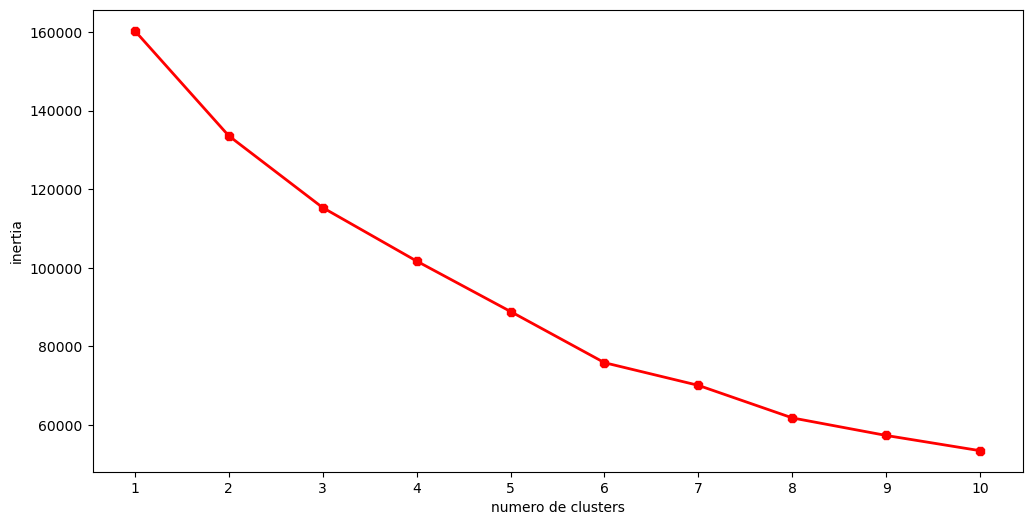

In [24]:
inertias = []

for k in range(1,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_airbnb_pca[df_airbnb_pca.columns])
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(1,11), inertias, linewidth=2, color='red', marker='8')
plt.xlabel('numero de clusters')
plt.xticks(range(1,11))
plt.ylabel('inertia')
plt.show()

- Creamos el modelo de Clusters concluyendo que, segun el punto de codo, habrá 5 clusters


In [21]:
km = KMeans(n_clusters=5)
clusters = km.fit_predict(df_airbnb_pca[df_airbnb_pca.columns])
df_airbnb_pca['cluster'] = clusters
df_airbnb_pca.head()

c:\Users\ALONSO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,0,1,2,3,4,5,6,cluster
0,-0.589353,0.788071,0.022806,-0.015754,0.335976,0.645315,-0.846877,0
1,-1.744819,-0.993006,-0.377590,-0.411415,0.521404,-1.123312,-0.644633,2
2,-0.190651,1.763345,-0.680279,0.931103,-0.889111,-0.665948,0.332502,0
3,-1.154727,0.650032,-0.444178,-0.516176,2.013750,-0.042346,-0.658012,2
4,1.535144,1.357111,1.154731,0.423481,0.444075,0.021446,-0.093595,1


- Visualizamos los datos con nuestro cluster, para ello vamos a realizar varias operaciones:
 → Primero, vamos a aplicar la columna cluster a nuestros datos sin normalizar
 → Después mostraremos en 3D la distribución del cluster

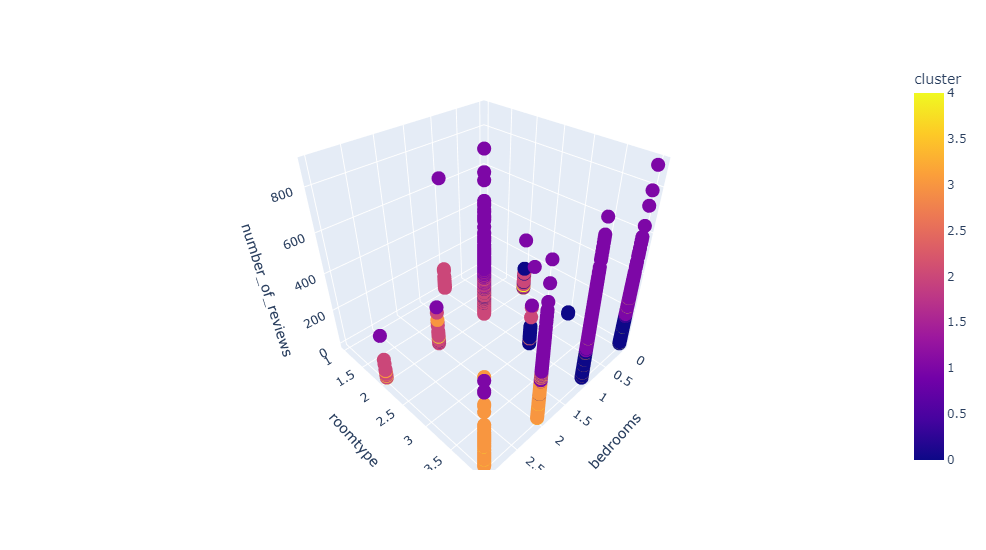

In [22]:


# Asignar los valores de 'clusters' a la columna 'cluster' en df_airbnb_clean
df_airbnb_clean['cluster'] = clusters

# Crear el scatterplot
fig = px.scatter_3d(df_airbnb_clean, z='number_of_reviews', y='roomtype', x='bedrooms', color='cluster')
fig.update_traces(marker=dict(symbol='circle'))

# Configurar el tamaño de la figura
fig.update_layout(width=750, height=550)

# Mostrar el plot
fig.show()



- Podemos ver que funciona muy efectivamente dividiendo por tipo de alquiler (casa entera, habitación de hotel, casa compartida...), número de habitaciones y cantidad de reviews. Aunque no necesariamente categoriza por precio (que en realidad sería lo más sencillo), vemos que sí que hay una lógica interna.

Realizamos un modelo de clasificación y comprobamos, en el classification report, que tiene una efectividad del 91%. 

In [23]:
#Modelo de clasificación

#Creamos eje x e y. En el eje y (target) colocamos los clusters que hemos creado en el clustering y en el eje x metemos las columnas que mejor separan los datos
x = df_airbnb_clean[["roomtype", "bedrooms", "number_of_reviews"]]
y = df_airbnb_clean["cluster"]

#Separacion de datos
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

#Lo primero es definir la k (número de vecinos)
k = 4

#Creación del modelo
knn_model = KNeighborsClassifier(n_neighbors=k)

#Ajustar el modelo al conjunto de datos
knn_model.fit(x_train, y_train)

#Hacemos la predicción
y_pred = knn_model.predict(x_test)
y_pred

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      1286
           1       0.85      0.96      0.90       186
           2       0.88      0.98      0.93      1072
           3       0.95      0.85      0.90       657
           4       0.00      0.00      0.00        84

    accuracy                           0.91      3285
   macro avg       0.72      0.74      0.73      3285
weighted avg       0.89      0.91      0.89      3285



c:\Users\ALONSO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALONSO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\ALONSO\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Este modelo de clasificación nos será útil con futuros registros de casas en alquiler en airbnb, que podremos asignar a nuestros clusters ya creados. Las conclusiones de este proyecto pueden consultarse en el pdf